In [1]:
# Notebook configuration
HNSWLIB_RESULTS_DIR = "./results"
GT_DIR = "/mnt/nas1/fvs_benchmark_datasets"
GXL_DIR = "/mnt/nas1/GXL/deep1B/v2.0_with250Mfix"
GXL_APU8_DIR = '/mnt/nas1/GXL/deep1B/v2.0_with250Mfix_8apus_apu3'

In [2]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib widget
%matplotlib inline
import ipywidgets as widgets

In [3]:
p = os.path.join(HNSWLIB_RESULTS_DIR, "vanilla_deep-1000M_64_32.csv")
df = pd.read_csv(p, delimiter='\t')
df

,Unnamed: 0,operation,start_time,end_time,walltime,units,dataset,numrecs,ef_construction,M,ef_search,labels,distances,memory
0,0,mem,2024-01-05 21:50:42.049791,-1,-1.000,seconds,-1,-1,-1,-1,-1,-1,-1,"[436067053568, 1108346249216, 25583616, 188416..."
1,1,mem,2024-01-05 21:50:54.926494,-1,-1.000,seconds,-1,-1,-1,-1,-1,-1,-1,"[444067581952, 1110505648128, 26697728, 188416..."
2,2,mem,2024-01-05 21:51:04.938450,-1,-1.000,seconds,-1,-1,-1,-1,-1,-1,-1,"[634337038336, 1322174935040, 26705920, 188416..."
3,3,mem,2024-01-05 21:51:14.950430,-1,-1.000,seconds,-1,-1,-1,-1,-1,-1,-1,"[652892299264, 1322185129984, 26705920, 188416..."
4,4,mem,2024-01-05 21:51:24.962434,-1,-1.000,seconds,-1,-1,-1,-1,-1,-1,-1,"[653554020352, 1322197061632, 26705920, 188416..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5660,5660,search,2024-01-06 02:29:06.057803,2024-01-06 02:29:06.061329,3.526,milliseconds,deep-1000M,1000000000,-1,-1,512,[[437207210 927427176 407039117 979113602 8943...,[[0.08722764 0.09719658 0.09889811 0.10090595 ...,-1
5661,5661,search,2024-01-06 02:29:06.061334,2024-01-06 02:29:06.063974,2.640,milliseconds,deep-1000M,1000000000,-1,-1,512,[[590525204 235546005 116917906 30794134 8112...,[[0.14016426 0.15490484 0.15500474 0.15509927 ...,-1
5662,5662,search,2024-01-06 02:29:06.063978,2024-01-06 02:29:06.066237,2.259,milliseconds,deep-1000M,1000000000,-1,-1,512,[[525421816 52137024 827171818 433320859 8368...,[[0.04198921 0.04652548 0.04764974 0.04877871 ...,-1
5663,5663,search,2024-01-06 02:29:06.066242,2024-01-06 02:29:06.069154,2.912,milliseconds,deep-1000M,1000000000,-1,-1,512,[[896131802 130468980 128550783 982216022 6318...,[[0.19145042 0.20499259 0.20652187 0.21191639 ...,-1


Text(0.5, 1.0, 'mem usage - deep 1000M')

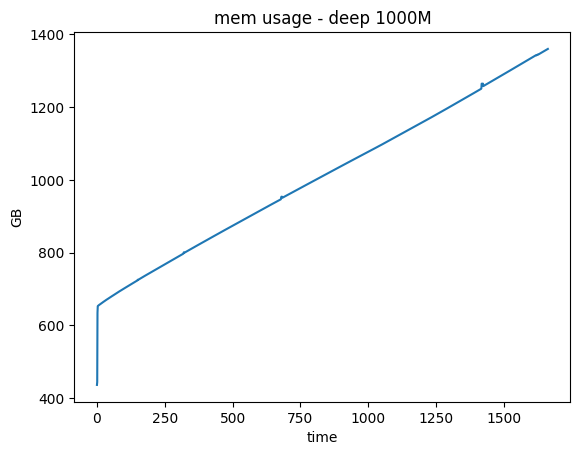

In [4]:
lst = []
for i in df[df.operation == 'mem'].memory:
    l = i[1:-1].split(',')[0]
    rss = int(l)/1000000000
    lst.append(rss)

plt.plot(lst)
plt.ylabel('GB')
plt.xlabel('time')
plt.title('mem usage - deep 1000M')
    

In [3]:
# Load CSV
vanilla_csvs = []
gxl_csvs = []
gxl_4_csvs = []
gxl_8_csvs = []

for file in os.listdir(HNSWLIB_RESULTS_DIR):
    print(file)
    if 'vanilla' in file:
        if file.endswith(".csv"):
            fpath = os.path.join(HNSWLIB_RESULTS_DIR, file)
            vanilla_csvs.append(fpath)
    elif 'gxl' in file and 'numactl' not in file:
        if file.endswith(".csv"):
            fpath = os.path.join(HNSWLIB_RESULTS_DIR, file)
            gxl_csvs.append(fpath)
    """elif 'numactl' in file:
        if file.endswith(".csv"):
            fpath = os.path.join(HNSWLIB_RESULTS_DIR, file)
            gxl_numactl_csvs.append(fpath)"""

# apu 4
for file in os.listdir(GXL_DIR):
    print(file)
    if file.endswith(".csv"):
        fpath = os.path.join(GXL_DIR, file)
        gxl_4_csvs.append(fpath)

# apu 8
for file in os.listdir(GXL_APU8_DIR):
    print(file)
    if file.endswith(".csv"):
        fpath = os.path.join(GXL_APU8_DIR, file)
        gxl_8_csvs.append(fpath)

           
if len(vanilla_csvs)==0:
    raise Exception("No CSVs found in vanilla!")
print("found %d CSV files for vanilla" % len(vanilla_csvs))
if len(gxl_csvs)==0:
    raise Exception("No CSVs found in gxl!")
print("found %d CSV files for gxl" % len(gxl_csvs))
if len(gxl_4_csvs)==0:
    raise Exception("No CSVs found in gxl w/ 4 apu!")
print("found %d CSV files for gxl w/ 4 apu" % len(gxl_4_csvs))
if len(gxl_8_csvs)==0:
    raise Exception("No CSVs found in gxl w/ 8 apu!")
print("found %d CSV files for gxl w/ 8 apu" % len(gxl_8_csvs))



gxl_load_deep1B_1m_ef_64_M_32_gxl_512.csv
gxl_load_deep1B_20m_ef_64_M_32_gxl_512.csv
vanilla_deep-500M_64_32.csv
vanilla_deep-50M_64_32.csv
vis
vanilla_deep-1000M_64_32.csv
vanilla_deep-10M_64_32.csv
vanilla_deep-20M_64_32.csv
gxl_load_deep1B_50m_ef_64_M_32_gxl_512.csv
vanilla_deep-1M_64_32.csv
gxl_load_deep1B_1000m_ef_64_M_32_gxl_512.csv
gxl_load_deep1B_100m_ef_64_M_32_gxl_512.csv
gxl_load_deep1B_250m_ef_64_M_32_gxl_512.csv
old
vanilla_deep-100M_64_32.csv
1129
gxl_load_deep1B_500m_ef_64_M_32_gxl_512.csv
gxl_load_deep1B_10m_ef_64_M_32_gxl_512.csv
vanilla_deep-250M_64_32.csv
deep1B_1m_ef_64_M_32_gxl.bin
deep1B_10m_ef_64_M_32_gxl.bin
deep1B_20m_ef_64_M_32_gxl.bin
deep1B_50m_ef_64_M_32_gxl.bin
deep1B_100m_ef_64_M_32_gxl.bin
deep1B_250m_ef_64_M_32_gxl.bin
deep-1M_1700158142.098489.csv
deep-10M_1700158355.068015.csv
deep-20M_1700158661.755577.csv
deep-50M_1700159398.912206.csv
deep-100M_1700160637.835966.csv
deep-250M_1700163449.826781.csv
deep1B_500m_ef_64_M_32_gxl.bin
deep-500M_1700773991

In [4]:
# Load to df
vanilla_dfs = []
gxl_dfs = []
gxl_4_dfs = []
gxl_8_dfs = []

for csv in vanilla_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    vanilla_dfs.append(df)

for csv in gxl_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    gxl_dfs.append(df)

for csv in gxl_4_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    gxl_4_dfs.append(df)

for csv in gxl_8_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    gxl_8_dfs.append(df)


# concat into one master
print("Concatenating into one master dataframe...")
vanilla_df = pd.concat( vanilla_dfs )
gxl_df = pd.concat( gxl_dfs )
gxl_4_df = pd.concat( gxl_4_dfs )
gxl_8_df = pd.concat( gxl_8_dfs )
print("There are %d rows" % vanilla_df.shape[0])
print("There are %d rows" % gxl_df.shape[0])
print("There are %d rows" % gxl_4_df.shape[0])
print("There are %d rows" % gxl_8_df.shape[0])



Concatenating into one master dataframe...
There are 35271 rows
There are 32008 rows
There are 40 rows
There are 40 rows


# RAM Usage

In [ ]:
lst = []
for i in df[df.operation == 'mem'].memory:
    l = i[1:-1].split(',')[0]
    rss = int(l)/1000000000
    lst.append(rss)

plt.plot(lst)
plt.ylabel('GB')
plt.xlabel('time')
plt.title('mem usage - deep 1000M')
    

In [14]:
v_df = vanilla_df[vanilla_df['operation'] == 'mem']
v_df['rss'] = v_df['memory'].apply(lambda x:int(x[1:-1].split(',')[0])/1000000000)
v_df = v_df[['dataset', 'numrecs', 'rss']]
v_df.head()

/tmp/ipykernel_594684/2159977094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['rss'] = v_df['memory'].apply(lambda x:int(x[1:-1].split(',')[0])/1000000000)


,dataset,numrecs,rss
0,deep-500M,500000000,218.067309
1,deep-500M,500000000,286.547390
2,deep-500M,500000000,326.798037
3,deep-500M,500000000,327.481205
4,deep-500M,500000000,328.115343


In [ ]:
g_pivot = pd.pivot_table(data=g_df, index=['numrecs'], columns=['subop'], values='walltime')
g_pivot

Text(0.5, 1.0, 'Memory Usage On Index Built - Deep1B')

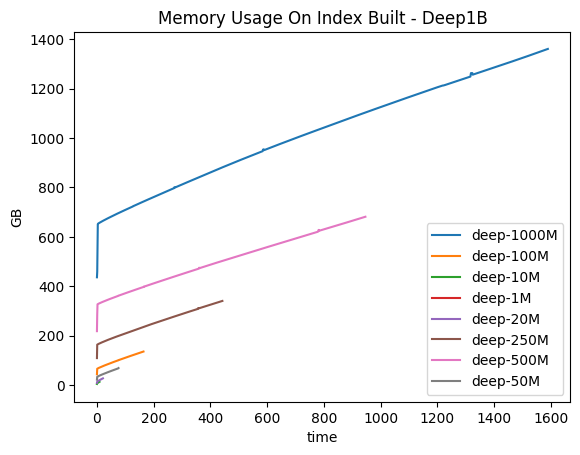

In [19]:
v_df.groupby('dataset')['rss'].plot(legend=True)
plt.ylabel('GB')
plt.xlabel('time')
plt.title('Memory Usage On Index Built - Deep1B')

## GT

In [7]:
def size_num(s):
    '''get raw numercs of text abbrev'''
    if s == '1M': return 1000000
    elif s == '2M': return 2000000
    elif s == '5M': return 5000000
    elif s == '10M': return 10000000
    elif s == '20M': return 20000000
    elif s == '50M': return 50000000
    elif s == '100M': return 100000000
    elif s == '200M': return 200000000
    elif s == '250M': return 250000000
    elif s == '500M': return 500000000
    elif s == '10K': return 10000
    elif s == '1000M': return 1000000000
    else: raise Exception("Unsupported size " + s)
    
def hsize(numrecs):
    '''get text abbrev of raw numrecs'''
    if numrecs==10000: return "10K"
    elif numrecs==1000000: return "1M"
    elif numrecs==2000000: return "2M"
    elif numrecs==5000000: return "5M"
    elif numrecs==10000000: return "10M"
    elif numrecs==20000000: return "20M"
    elif numrecs==50000000: return "50M"
    elif numrecs==100000000: return "100M"
    elif numrecs==250000000: return "250M"
    elif numrecs==500000000: return "500M"
    elif numrecs==1000000000: return "1000M"
    else: raise Exception("Unsupported size" + str(numrecs))
    
def compute_recall(a, b):
    '''Computes the recall metric on query results.'''

    nq, rank = a.shape
    intersect = [ np.intersect1d(a[i, :rank], b[i, :rank]).size for i in range(nq) ]
    ninter = sum( intersect )
    return ninter / a.size, intersect

In [9]:
dic = {}
recall10_mean = []
latency_mean = []
numrecs_lst = []
ef_search_lst = []

for numrecs in vanilla_df['numrecs'].unique():
    if numrecs == -1:
        continue
    
    ef_unique = vanilla_df.ef_search.unique().tolist()
    ef_unique.remove(-1)

    num_records = hsize(numrecs)
    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)
    gt = np.load(gt_file, allow_pickle=True)

    for ef_search in ef_unique:
        recall_lst = []
        latency_lst = []
        
        df = vanilla_df[(vanilla_df['ef_search']== ef_search) & (vanilla_df['numrecs'] == numrecs)]
        if len(df) != 1000:
            raise Exception("not equal to 1000")

        for j in range(len(df)):
            row = df.iloc[j]
            lbl = row.labels
            latency = row.walltime

            # transform lbl
            lbl_trunc = lbl[2:-2]
            lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=' ')
            lbl_reshape = lbl_converted.reshape(1, 10)
            gt_reshape = gt[j][:10].reshape(1, 10)

            # compute recall
            recall, cnt = compute_recall(gt_reshape, lbl_reshape)
            recall_lst.append(recall)
            latency_lst.append(latency)

           
        recall10_mean.append(np.mean(recall_lst))
        latency_mean.append(np.mean(latency_lst))
        numrecs_lst.append(num_records)
        ef_search_lst.append(ef_search)
        print(num_records, ef_search, len(recall_lst), np.mean(recall_lst), np.mean(latency_lst))
dic = {'numrecs':numrecs_lst, 'ef_search':ef_search_lst, 'recall@10':recall10_mean, 'latency':latency_mean} 
vanilla_result_df = pd.DataFrame(dic)
        


1000M 64 1000 0.8036 0.532317
1000M 128 1000 0.8712000000000001 0.862601
1000M 256 1000 0.9232 1.59008
1000M 512 1000 0.9555 2.9839729999999998
10M 64 1000 0.9141000000000001 0.33913499999999996
10M 128 1000 0.957 0.7543340000000001
10M 256 1000 0.9785999999999999 1.4212939999999998
10M 512 1000 0.9892000000000001 2.318727
500M 64 1000 0.8178000000000001 0.592424
500M 128 1000 0.8895 1.04349
500M 256 1000 0.9345 1.7257240000000003
500M 512 1000 0.9614 3.021589
10K 64 1000 0.9956 0.06308499999999999
10K 128 1000 0.9992000000000001 0.09899399999999998
10K 256 1000 1.0 0.17837199999999998
10K 512 1000 1.0 0.334013
100M 64 1000 0.8563000000000001 0.453221
100M 128 1000 0.917 0.7502089999999999
100M 256 1000 0.9546 1.369657
100M 512 1000 0.9758000000000001 2.539644
1M 64 1000 0.9491 0.235173
1M 128 1000 0.978 0.3813729999999999
1M 256 1000 0.9914 0.675539
1M 512 1000 0.9966999999999999 1.44527
20M 64 1000 0.8969000000000001 0.6687219999999999
20M 128 1000 0.9479000000000001 0.82552699999999

In [10]:
dic = {}
recall10_mean = []
latency_mean = []
numrecs_lst = []
ef_search_lst = []

for numrecs in gxl_df['numrecs'].unique():
    ef_unique = gxl_df.ef_search.unique().tolist()
    ef_unique.remove(-1)

    num_records = hsize(numrecs)
    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)
    gt = np.load(gt_file, allow_pickle=True)

    for ef_search in ef_unique:
        recall_lst = []
        latency_lst = []
        
        df = gxl_df[(gxl_df['ef_search']== ef_search) & (gxl_df['numrecs'] == numrecs)]
        if len(df) != 1000:
            raise Exception("not equal to 1000")

        for j in range(len(df)):
            row = df.iloc[j]
            lbl = row.labels
            latency = row.walltime

            # transform lbl
            lbl_trunc = lbl[2:-2]
            lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=' ')
            lbl_reshape = lbl_converted.reshape(1, 10)
            gt_reshape = gt[j][:10].reshape(1, 10)

            # compute recall
            recall, cnt = compute_recall(gt_reshape, lbl_reshape)
            recall_lst.append(recall)
            latency_lst.append(latency)

           
        recall10_mean.append(np.mean(recall_lst))
        latency_mean.append(np.mean(latency_lst))
        numrecs_lst.append(num_records)
        ef_search_lst.append(ef_search)
        print(num_records, ef_search, len(recall_lst), np.mean(recall_lst), np.mean(latency_lst))
dic = {'numrecs':numrecs_lst, 'ef_search':ef_search_lst, 'recall@10':recall10_mean, 'latency':latency_mean} 
gxl_result_df = pd.DataFrame(dic)
        


1M 64 1000 0.9748000000000001 0.839828
1M 128 1000 0.9909000000000001 1.426993
1M 256 1000 0.9974000000000001 2.564922
1M 512 1000 0.9990999999999999 4.516747
20M 64 1000 0.9378 0.486562
20M 128 1000 0.9713 0.8252430000000001
20M 256 1000 0.988 1.508037
20M 512 1000 0.9946 2.7918819999999998
50M 64 1000 0.917 0.5652539999999999
50M 128 1000 0.9596 0.927114
50M 256 1000 0.982 1.705781
50M 512 1000 0.9933 3.1631380000000004
1000M 64 1000 0.8318 2.6211580000000003
1000M 128 1000 0.8994000000000001 1.581971
1000M 256 1000 0.9472999999999999 2.9983940000000002
1000M 512 1000 0.9744 5.734781000000001
100M 64 1000 0.9016000000000001 1.382641
100M 128 1000 0.9495 2.0738250000000003
100M 256 1000 0.9752000000000001 4.792348
100M 512 1000 0.9885 12.528867
250M 64 1000 0.8736 0.82149
250M 128 1000 0.9321 1.044417
250M 256 1000 0.9668 1.888232
250M 512 1000 0.9847 3.5594189999999997
500M 64 1000 0.8522000000000001 3.439807
500M 128 1000 0.9137000000000001 3.964375
500M 256 1000 0.9569 8.267779
500

In [11]:
"""dic = {}
recall10_mean = []
latency_mean = []
numrecs_lst = []
ef_search_lst = []

for numrecs in gxl_numactl_df['numrecs'].unique():
    ef_unique = gxl_numactl_df.ef_search.unique().tolist()
    ef_unique.remove(-1)

    num_records = hsize(numrecs)
    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)
    gt = np.load(gt_file, allow_pickle=True)

    for ef_search in ef_unique:
        recall_lst = []
        latency_lst = []
        
        df = gxl_numactl_df[(gxl_numactl_df['ef_search']== ef_search) & (gxl_numactl_df['numrecs'] == numrecs)]
        if len(df) != 1000:
            raise Exception("not equal to 1000")

        for j in range(len(df)):
            row = df.iloc[j]
            lbl = row.labels
            latency = row.walltime

            # transform lbl
            lbl_trunc = lbl[2:-2]
            lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=' ')
            lbl_reshape = lbl_converted.reshape(1, 10)
            gt_reshape = gt[j][:10].reshape(1, 10)

            # compute recall
            recall, cnt = compute_recall(gt_reshape, lbl_reshape)
            recall_lst.append(recall)
            latency_lst.append(latency)

           
        recall10_mean.append(np.mean(recall_lst))
        latency_mean.append(np.mean(latency_lst))
        numrecs_lst.append(num_records)
        ef_search_lst.append(ef_search)
        print(num_records, ef_search, len(recall_lst), np.mean(recall_lst), np.mean(latency_lst))
dic = {'numrecs':numrecs_lst, 'ef_search':ef_search_lst, 'recall@10':recall10_mean, 'latency':latency_mean} 
gxl_numactl_result_df = pd.DataFrame(dic)
        
"""

'dic = {}\nrecall10_mean = []\nlatency_mean = []\nnumrecs_lst = []\nef_search_lst = []\n\nfor numrecs in gxl_numactl_df[\'numrecs\'].unique():\n    ef_unique = gxl_numactl_df.ef_search.unique().tolist()\n    ef_unique.remove(-1)\n\n    num_records = hsize(numrecs)\n    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)\n    gt = np.load(gt_file, allow_pickle=True)\n\n    for ef_search in ef_unique:\n        recall_lst = []\n        latency_lst = []\n        \n        df = gxl_numactl_df[(gxl_numactl_df[\'ef_search\']== ef_search) & (gxl_numactl_df[\'numrecs\'] == numrecs)]\n        if len(df) != 1000:\n            raise Exception("not equal to 1000")\n\n        for j in range(len(df)):\n            row = df.iloc[j]\n            lbl = row.labels\n            latency = row.walltime\n\n            # transform lbl\n            lbl_trunc = lbl[2:-2]\n            lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=\' \')\n            lbl_reshape = lbl_converted.reshape(

In [12]:
# p90/95/99 latency, show not just mean, capture in a csv
# error bar along y axis, range, interval, stats interval, boxplots intervals, coretile analysis for recall

In [73]:
def plot_paretto(num_records):

    df_vanilla = vanilla_result_df[ vanilla_result_df['numrecs'] == num_records]
    print(df_vanilla )
    df_gxl = gxl_result_df[ gxl_result_df['numrecs'] == num_records]
    print(df_gxl )
    #df_gxl_numactl = gxl_numactl_result_df[ gxl_numactl_result_df['numrecs'] == num_records]
    #print(df_gxl_numactl)

    # extract the lines for plotting
    paretto_vanilla_parameters = list(df_vanilla ['ef_search'])
    paretto_vanilla_search = list(df_vanilla ['latency'])
    paretto_vanilla_recall = list(df_vanilla ['recall@10'])
    print(paretto_vanilla_search, paretto_vanilla_recall)

    paretto_gxl_parameters = list(df_gxl ['ef_search'])
    paretto_gxl_search = list(df_gxl ['latency'])
    paretto_gxl_recall = list(df_gxl ['recall@10'])
    print(paretto_gxl_search, paretto_gxl_recall)

    """paretto_gxl_numactl_parameters = list(df_gxl_numactl ['ef_search'])
    paretto_gxl_numactl_search = list(df_gxl_numactl ['latency'])
    paretto_gxl_numactl_recall = list(df_gxl_numactl ['recall@10'])
    print(paretto_gxl_numactl_search, paretto_gxl_numactl_recall)"""

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(paretto_vanilla_search, paretto_vanilla_recall, marker='x', color='blue', label='vanilla HNSW')
    ax.plot(paretto_gxl_search, paretto_gxl_recall, marker='x', color='orange', label='gxl HNSW')
    #ax.plot(paretto_gxl_numactl_search, paretto_gxl_numactl_recall, marker='x', color='green', label='gxl with numactl HNSW')

    # annotate hnsw
    for i, bits in enumerate(paretto_vanilla_parameters):
        ax.annotate("ef=%d"%bits, 
                xy=(paretto_vanilla_search[i],paretto_vanilla_recall[i]-0.005 ), 
                xytext=(0.0,7),
                textcoords="offset points"
                )
    for i, bits in enumerate(paretto_gxl_parameters):
        ax.annotate("ef=%d"%bits, 
                xy=(paretto_gxl_search[i],paretto_gxl_recall[i]-0.005 ), 
                xytext=(0.0,7),
                textcoords="offset points"
                )
    
    """ for i, bits in enumerate(paretto_gxl_numactl_parameters):
        ax.annotate("ef=%d"%bits, 
                xy=(paretto_gxl_numactl_search[i],paretto_gxl_numactl_recall[i]-0.005 ), 
                xytext=(0.0,7),
                textcoords="offset points"
                )"""

    ax.set_xlabel("Q-by-Q Latency (milliseconds)")
    ax.set_ylabel("Recall@10")
    title = f"HNSWLIB Vanilla vs. GXL - {num_records} Records of Deep1B"
    plt.title(title)
    ax.legend(loc='lower right', fontsize='small')

    save_path = f'results/vis/vanilla_gxl_paretto{num_records}.png'

    fig.savefig(save_path)

    return "done"
    

   numrecs  ef_search  recall@10   latency
20      1M         64     0.9491  0.235173
21      1M        128     0.9780  0.381373
22      1M        256     0.9914  0.675539
23      1M        512     0.9967  1.445270
  numrecs  ef_search  recall@10   latency
0      1M         64     0.9748  0.839828
1      1M        128     0.9909  1.426993
2      1M        256     0.9974  2.564922
3      1M        512     0.9991  4.516747
[0.235173, 0.3813729999999999, 0.675539, 1.44527] [0.9491, 0.978, 0.9914, 0.9966999999999999]
[0.839828, 1.426993, 2.564922, 4.516747] [0.9748000000000001, 0.9909000000000001, 0.9974000000000001, 0.9990999999999999]
  numrecs  ef_search  recall@10   latency
4     10M         64     0.9141  0.339135
5     10M        128     0.9570  0.754334
6     10M        256     0.9786  1.421294
7     10M        512     0.9892  2.318727
   numrecs  ef_search  recall@10   latency
28     10M         64     0.9496  0.439169
29     10M        128     0.9791  0.743955
30     10M        25

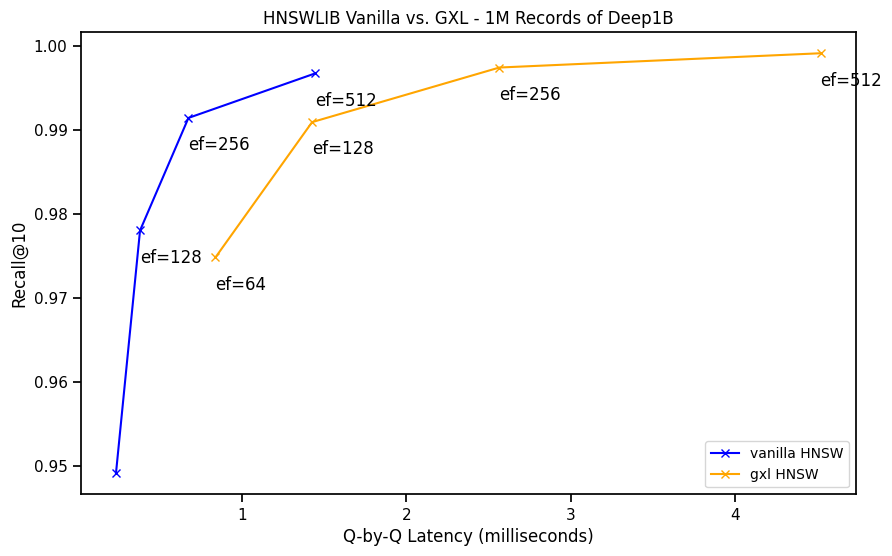

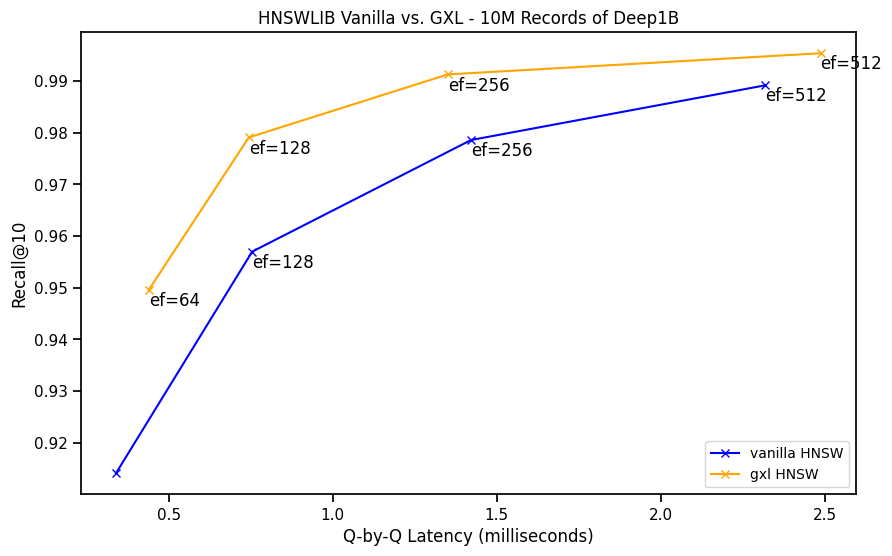

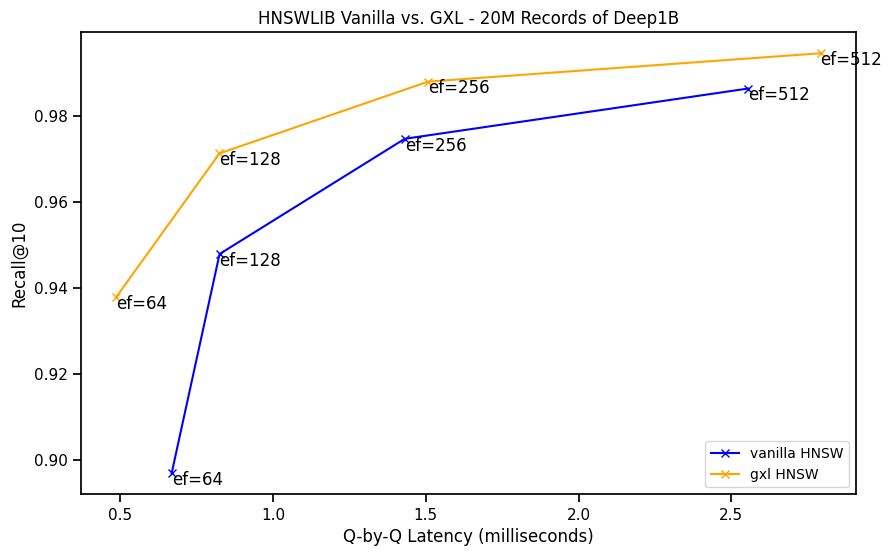

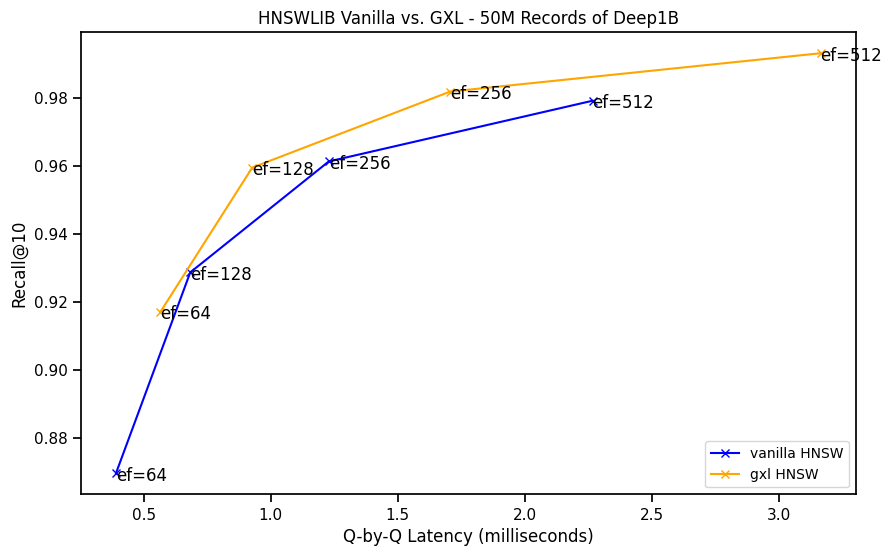

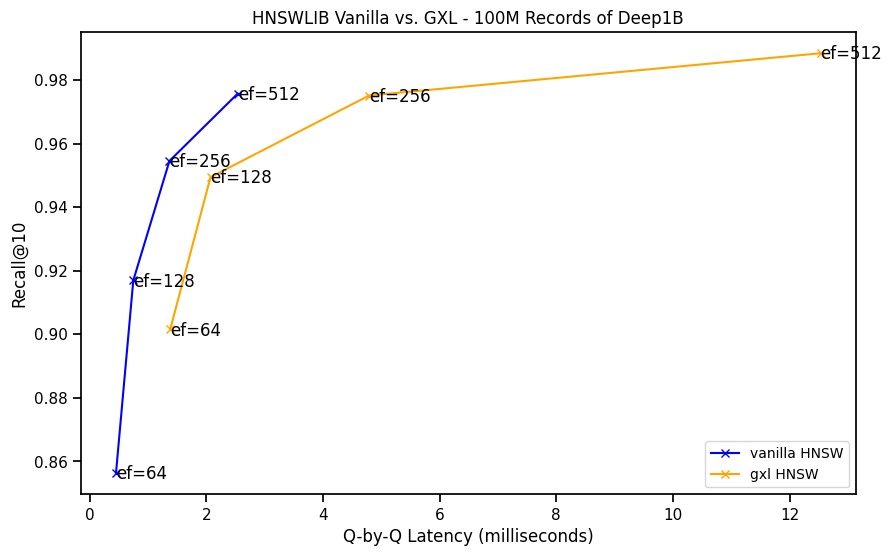

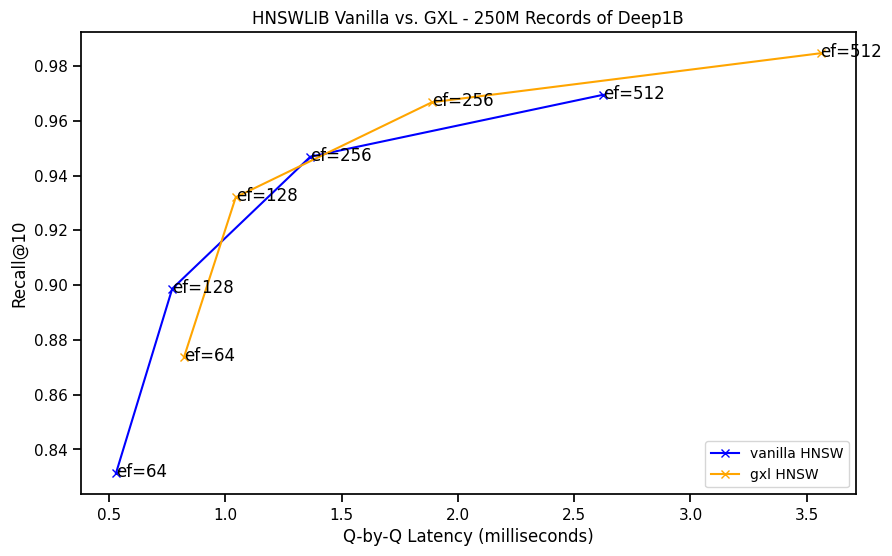

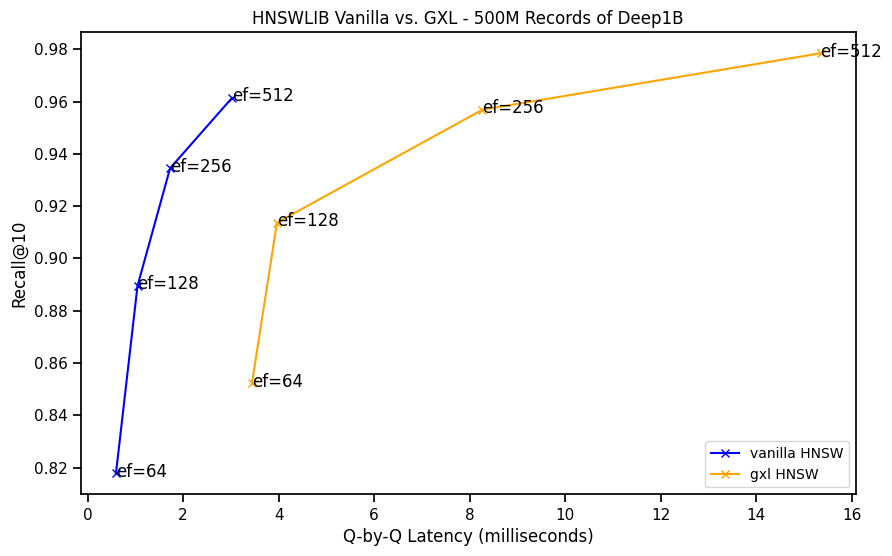

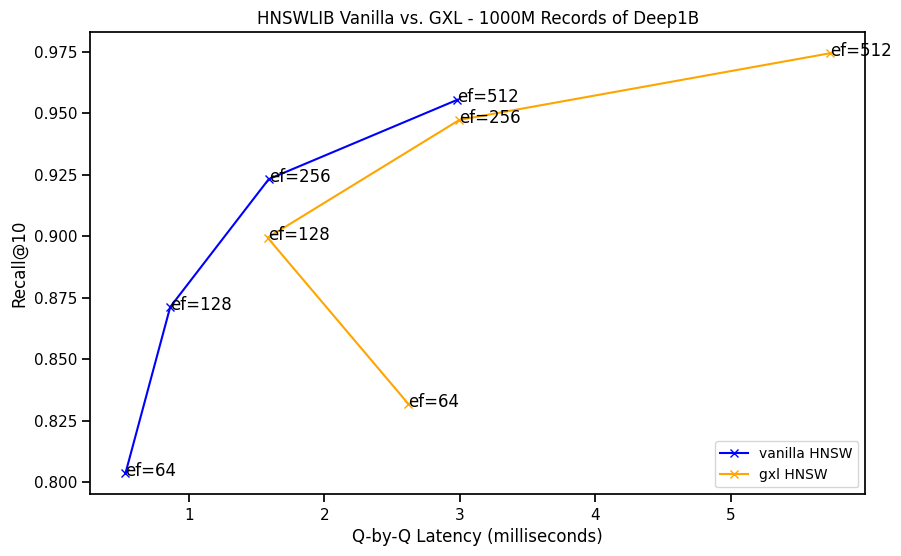

In [74]:
lst = ['1M', '10M', '20M', '50M', '100M', '250M', '500M', '1000M']
for i in lst:
    plot_paretto(i)

# plot search time

In [ ]:
"""# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
avg_search_walltime = \
    vanilla_df[vanilla_df['operation'] == 'search'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_walltime.index:
    x = idx
    xs.append(x)
    #y = avg_search_wall_import_time[idx]/(1000*60.0*60.0) # milliseconds
    y = avg_search_walltime[idx] # milliseconds
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('milliseconds')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M', '500M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB Vanilla Search Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/vanilla_hnswlib_walltime.png")"""

'# plot one line of latest, matching label with the og notebook \n# Plot import/train times\n\n# compute average wall import time via groupby\navg_search_walltime =     vanilla_df[vanilla_df[\'operation\'] == \'search\'].groupby( [ \'numrecs\' ] ) [\'walltime\'].mean()\n\n# get the plot points for import time\nxs = []\nys = []\nfor idx in avg_search_walltime.index:\n    x = idx\n    xs.append(x)\n    #y = avg_search_wall_import_time[idx]/(1000*60.0*60.0) # milliseconds\n    y = avg_search_walltime[idx] # milliseconds\n    ys.append(y)\nprint("vanilla search time", xs, ys)\n\n# plot the lines and label the plot\nfig, ax = plt.subplots()\n\n#\n# only show the wall time lines\n#\nax.plot(xs, ys, marker=\'x\', label=\'vanilla\')\nax.set_ylabel(\'milliseconds\')\nax.set_xlabel(\'num records\')\nax.set_xticks(xs)\n\n# don\'t show all xticks near the start since they bunch up\nax.set_xticklabels([\'1M\', \'\', \'20M\', \'50M\', \'100M\', \'250M\', \'500M\'], rotation = 45)\n\n#\n# annotate la

In [ ]:
"""# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
avg_search_wall_time = \
    gxl_df[gxl_df['operation'] == 'search'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_wall_time.index:
    x = idx
    xs.append(x)
    y = avg_search_wall_time[idx]/(1000*60.0*60.0)
    ys.append(y)
print("gxl search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M', '500M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB GXL Search Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/gxl_hnswlib_search_walltime.png")"""

'# plot one line of latest, matching label with the og notebook \n# Plot import/train times\n\n# compute average wall import time via groupby\navg_search_wall_time =     gxl_df[gxl_df[\'operation\'] == \'search\'].groupby( [ \'numrecs\' ] ) [\'walltime\'].mean()\n\n# get the plot points for import time\nxs = []\nys = []\nfor idx in avg_search_wall_time.index:\n    x = idx\n    xs.append(x)\n    y = avg_search_wall_time[idx]/(1000*60.0*60.0)\n    ys.append(y)\nprint("gxl search time", xs, ys)\n\n# plot the lines and label the plot\nfig, ax = plt.subplots()\n\n#\n# only show the wall time lines\n#\nax.plot(xs, ys, marker=\'x\', label=\'vanilla\')\nax.set_ylabel(\'hours\')\nax.set_xlabel(\'num records\')\nax.set_xticks(xs)\n\n# don\'t show all xticks near the start since they bunch up\nax.set_xticklabels([\'1M\', \'\', \'20M\', \'50M\', \'100M\', \'250M\', \'500M\'], rotation = 45)\n\n#\n# annotate last data point in lines of interest\nlatest_hours = "%.1f" % ys[-1]\nax.annotate(latest_ho

# plot build/load time

In [ ]:
"""# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
avg_wall_import_time = \
    vanilla_df[vanilla_df['operation'] == 'build'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_wall_import_time.index:
    x = idx
    xs.append(x)
    y = avg_wall_import_time[idx]/(60.0*60.0)
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M', '500M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB Vanilla Build Index Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/vanilla_hnswlib_walltime_build.png")"""

'# plot one line of latest, matching label with the og notebook \n# Plot import/train times\n\n# compute average wall import time via groupby\navg_wall_import_time =     vanilla_df[vanilla_df[\'operation\'] == \'build\'].groupby( [ \'numrecs\' ] ) [\'walltime\'].mean()\n\n# get the plot points for import time\nxs = []\nys = []\nfor idx in avg_wall_import_time.index:\n    x = idx\n    xs.append(x)\n    y = avg_wall_import_time[idx]/(60.0*60.0)\n    ys.append(y)\nprint("vanilla search time", xs, ys)\n\n# plot the lines and label the plot\nfig, ax = plt.subplots()\n\n#\n# only show the wall time lines\n#\nax.plot(xs, ys, marker=\'x\', label=\'vanilla\')\nax.set_ylabel(\'hours\')\nax.set_xlabel(\'num records\')\nax.set_xticks(xs)\n\n# don\'t show all xticks near the start since they bunch up\nax.set_xticklabels([\'1M\', \'\', \'20M\', \'50M\', \'100M\', \'250M\', \'500M\'], rotation = 45)\n\n#\n# annotate last data point in lines of interest\nlatest_hours = "%.1f" % ys[-1]\nax.annotate(lat

In [ ]:
"""# Plot walltime

# compute average search walltime via groupby
avg_search_wall_time = \
    gxl_df[gxl_df['operation'] == 'load'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_walltime.index:
    x = idx
    xs.append(x)
    y = avg_search_walltime[idx] # milliseconds
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('milliseconds')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M', '500M'], rotation = 45)

ax.set_title("HNSWLIB GXL Load Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/gxl_load_walltime.png")"""

'# Plot walltime\n\n# compute average search walltime via groupby\navg_search_wall_time =     gxl_df[gxl_df[\'operation\'] == \'load\'].groupby( [ \'numrecs\' ] ) [\'walltime\'].mean()\n\n# get the plot points for import time\nxs = []\nys = []\nfor idx in avg_search_walltime.index:\n    x = idx\n    xs.append(x)\n    y = avg_search_walltime[idx] # milliseconds\n    ys.append(y)\nprint("vanilla search time", xs, ys)\n\n# plot the lines and label the plot\nfig, ax = plt.subplots()\n\n#\n# only show the wall time lines\n#\nax.plot(xs, ys, marker=\'x\', label=\'vanilla\')\nax.set_ylabel(\'milliseconds\')\nax.set_xlabel(\'num records\')\nax.set_xticks(xs)\n\n# don\'t show all xticks near the start since they bunch up\nax.set_xticklabels([\'1M\', \'\', \'20M\', \'50M\', \'100M\', \'250M\', \'500M\'], rotation = 45)\n\nax.set_title("HNSWLIB GXL Load Time - Subsets of Deep-1B - apu12")\nax.legend(loc=\'best\')\nfig.tight_layout()\nfig.savefig("results/vis/gxl_load_walltime.png")'

# Import GXL Index Build Time

In [24]:
GXL_PATH = "/mnt/nas1/GXL/deep1B/v2.0_with250Mfix"
#NUMACTL_PATH = "/tmp/gxl_1701298133"
#tmp_path = "/tmp/gxl_1702413856/"
apu8_path = '/mnt/nas1/GXL/deep1B/v2.0_with250Mfix_8apus_apu3'



In [25]:
# Load CSV
gxl_index_csvs = []

for file in os.listdir(GXL_PATH):
    print(file)
    if file.endswith(".csv"):
        fpath = os.path.join(GXL_PATH, file)
        gxl_index_csvs.append(fpath)

"""for file in os.listdir(tmp_path):
    print(file)
    if file.endswith(".csv"):
        fpath = os.path.join(tmp_path, file)
        gxl_index_csvs.append(fpath)"""

if len(gxl_index_csvs)==0:
    raise Exception("No CSVs found in vanilla!")
print("found %d CSV files for gxl index build" % len(gxl_index_csvs))


deep1B_1m_ef_64_M_32_gxl.bin
deep1B_10m_ef_64_M_32_gxl.bin
deep1B_20m_ef_64_M_32_gxl.bin
deep1B_50m_ef_64_M_32_gxl.bin
deep1B_100m_ef_64_M_32_gxl.bin
deep1B_250m_ef_64_M_32_gxl.bin
deep-1M_1700158142.098489.csv
deep-10M_1700158355.068015.csv
deep-20M_1700158661.755577.csv
deep-50M_1700159398.912206.csv
deep-100M_1700160637.835966.csv
deep-250M_1700163449.826781.csv
deep1B_500m_ef_64_M_32_gxl.bin
deep-500M_1700773991.855970.csv
deep-1000M_1702426862.704299.csv
deep1B_1000m_ef_64_M_32_gxl.bin
found 8 CSV files for gxl index build


In [26]:
# Load CSV - 8 apu
gxl_8_index_csvs = []

for file in os.listdir(apu8_path):
    print(file)
    if file.endswith(".csv"):
        fpath = os.path.join(apu8_path, file)
        gxl_8_index_csvs.append(fpath)


if len(gxl_8_index_csvs)==0:
    raise Exception("No CSVs found in apu 8!")
print("found %d CSV files for gxl index build" % len(gxl_8_index_csvs))


deep-10M_1702497020.205433.csv
deep-250M_1702503473.842740.csv
deep-20M_1702497218.473179.csv
deep-100M_1702498565.936199.csv
deep-50M_1702497693.751691.csv
deep-1M_1702496911.447310.csv
deep-500M_1702657757.071652.csv
deep-1000M_1703296067.145159.csv
found 8 CSV files for gxl index build


In [27]:
"""# Load CSV numactl
gxl_numactl_index_csvs = []

for file in os.listdir(NUMACTL_PATH):
    print(file)
    if file.endswith(".csv"):
        fpath = os.path.join(NUMACTL_PATH, file)
        gxl_numactl_index_csvs.append(fpath)

if len(gxl_numactl_index_csvs)==0:
    raise Exception("No CSVs found in NUMACTL GXL!")
print("found %d CSV files for gxl index build" % len(gxl_numactl_index_csvs))
"""

'# Load CSV numactl\ngxl_numactl_index_csvs = []\n\nfor file in os.listdir(NUMACTL_PATH):\n    print(file)\n    if file.endswith(".csv"):\n        fpath = os.path.join(NUMACTL_PATH, file)\n        gxl_numactl_index_csvs.append(fpath)\n\nif len(gxl_numactl_index_csvs)==0:\n    raise Exception("No CSVs found in NUMACTL GXL!")\nprint("found %d CSV files for gxl index build" % len(gxl_numactl_index_csvs))\n'

In [28]:
# Load to df
gxl_index_dfs = []

for csv in gxl_index_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    print(csv)
    gxl_index_dfs.append(df)

# concat into one master
print("Concatenating into one master dataframe...")
gxl_index_df = pd.concat( gxl_index_dfs )
print("There are %d rows" % gxl_index_df.shape[0])
gxl_index_df.head()

/mnt/nas1/GXL/deep1B/v2.0_with250Mfix/deep-1M_1700158142.098489.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix/deep-10M_1700158355.068015.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix/deep-20M_1700158661.755577.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix/deep-50M_1700159398.912206.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix/deep-100M_1700160637.835966.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix/deep-250M_1700163449.826781.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix/deep-500M_1700773991.855970.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix/deep-1000M_1702426862.704299.csv
Concatenating into one master dataframe...
There are 40 rows


,Unnamed: 0,operation,subop,numboards,board_details,version,start,end,walltime,dataset,cpunodebind,preferred
0,0,ledainfo,boards,4.0,"[""\x1b[1m\x1b[33mslot0\x1b[0m {'Apuc_Mask': '0...",NaN,NaN,NaN,NaN,deep-1M,NaN,NaN
1,1,build-index,cen_gen,NaN,NaN,GXL version 2.0,2023-11-16 10:08:33.552025,2023-11-16 10:08:41.556780,8.004755,deep-1M,NaN,NaN
2,2,build-index,knn_gen,NaN,NaN,GXL version 2.0,2023-11-16 10:08:41.556829,2023-11-16 10:09:00.434040,18.877211,deep-1M,NaN,NaN
3,3,build-index,knn_symmetric,NaN,NaN,GXL version 2.0,2023-11-16 10:09:00.434087,2023-11-16 10:09:01.153263,0.719176,deep-1M,NaN,NaN
4,4,build-index,index_gen,NaN,NaN,exesize=104096,2023-11-16 10:09:01.153309,2023-11-16 10:09:02.092263,0.938954,deep-1M,NaN,NaN


In [29]:
# Load to df
gxl_8_index_dfs = []

for csv in gxl_8_index_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    print(csv)
    gxl_8_index_dfs.append(df)

# concat into one master
print("Concatenating into one master dataframe...")
gxl_8_index_df = pd.concat( gxl_8_index_dfs )
print("There are %d rows" % gxl_8_index_df.shape[0])
gxl_8_index_df.head()

/mnt/nas1/GXL/deep1B/v2.0_with250Mfix_8apus_apu3/deep-10M_1702497020.205433.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix_8apus_apu3/deep-250M_1702503473.842740.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix_8apus_apu3/deep-20M_1702497218.473179.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix_8apus_apu3/deep-100M_1702498565.936199.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix_8apus_apu3/deep-50M_1702497693.751691.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix_8apus_apu3/deep-1M_1702496911.447310.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix_8apus_apu3/deep-500M_1702657757.071652.csv
/mnt/nas1/GXL/deep1B/v2.0_with250Mfix_8apus_apu3/deep-1000M_1703296067.145159.csv
Concatenating into one master dataframe...
There are 40 rows


,Unnamed: 0,operation,subop,numboards,board_details,cpunodebind,preferred,version,start,end,walltime,dataset
0,0,ledainfo,boards,8.0,"[""\x1b[1m\x1b[33mslot0\x1b[0m {'Apuc_Mask': '0...",NaN,NaN,NaN,NaN,NaN,NaN,deep-10M
1,1,build-index,cen_gen,NaN,NaN,NaN,NaN,GXL version 2.0,2023-12-13 19:48:40.096827,2023-12-13 19:49:10.754385,30.657558,deep-10M
2,2,build-index,knn_gen,NaN,NaN,NaN,NaN,GXL version 2.0,2023-12-13 19:49:10.754452,2023-12-13 19:50:01.648338,50.893886,deep-10M
3,3,build-index,knn_symmetric,NaN,NaN,NaN,NaN,GXL version 2.0,2023-12-13 19:50:01.648401,2023-12-13 19:50:11.487120,9.838719,deep-10M
4,4,build-index,index_gen,NaN,NaN,NaN,NaN,exesize=104096,2023-12-13 19:50:11.487186,2023-12-13 19:50:20.199198,8.712012,deep-10M


In [30]:
"""# Load to df numactl
gxl_numactl_index_dfs = []

for csv in gxl_numactl_index_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    gxl_numactl_index_dfs.append(df)

# concat into one master
print("Concatenating into one master dataframe...")
gxl_numactl_index_df = pd.concat( gxl_numactl_index_dfs )
print("There are %d rows" % gxl_numactl_index_df.shape[0])
gxl_numactl_index_df.head()"""

'# Load to df numactl\ngxl_numactl_index_dfs = []\n\nfor csv in gxl_numactl_index_csvs:\n    df = pd.read_csv(csv, delimiter=\'\t\')\n    gxl_numactl_index_dfs.append(df)\n\n# concat into one master\nprint("Concatenating into one master dataframe...")\ngxl_numactl_index_df = pd.concat( gxl_numactl_index_dfs )\nprint("There are %d rows" % gxl_numactl_index_df.shape[0])\ngxl_numactl_index_df.head()'

In [31]:
g_df = gxl_index_df[['operation', 'subop', 'walltime', 'dataset']] # seconds
g_df = g_df[g_df['operation'] == 'build-index']
g_df['numrecs'] = g_df['dataset'].apply(lambda x: size_num(x[5:]))
g_df.head()

,operation,subop,walltime,dataset,numrecs
1,build-index,cen_gen,8.004755,deep-1M,1000000
2,build-index,knn_gen,18.877211,deep-1M,1000000
3,build-index,knn_symmetric,0.719176,deep-1M,1000000
4,build-index,index_gen,0.938954,deep-1M,1000000
1,build-index,cen_gen,44.826533,deep-10M,10000000


In [32]:
g_8_df = gxl_8_index_df[['operation', 'subop', 'walltime', 'dataset']] # seconds
g_8_df = g_8_df[g_8_df['operation'] == 'build-index']
g_8_df['numrecs'] = g_8_df['dataset'].apply(lambda x: size_num(x[5:]))
g_8_df.head()

,operation,subop,walltime,dataset,numrecs
1,build-index,cen_gen,30.657558,deep-10M,10000000
2,build-index,knn_gen,50.893886,deep-10M,10000000
3,build-index,knn_symmetric,9.838719,deep-10M,10000000
4,build-index,index_gen,8.712012,deep-10M,10000000
1,build-index,cen_gen,457.853268,deep-250M,250000000


In [33]:
g_pivot = pd.pivot_table(data=g_df, index=['numrecs'], columns=['subop'], values='walltime')
g_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric
numrecs,,,,
1000000,8.004755,0.938954,18.877211,0.719176
10000000,44.826533,11.759718,83.071893,7.102119
20000000,82.985654,21.666023,165.239255,14.505771
50000000,218.629373,56.033163,394.741625,42.915334
100000000,238.232299,105.779660,767.895688,101.182567
250000000,349.322762,297.052899,1903.636211,227.800315
500000000,689.964442,595.208836,3834.971609,475.139651
1000000000,1691.969357,2358.502926,7786.722898,1150.803178


In [34]:
g_8_pivot = pd.pivot_table(data=g_8_df, index=['numrecs'], columns=['subop'], values='walltime')
g_8_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric
numrecs,,,,
1000000,5.297143,0.891214,15.217803,0.742396
10000000,30.657558,8.712012,50.893886,9.838719
20000000,59.583047,18.068238,90.240671,21.893816
50000000,140.690370,50.419851,213.078564,62.713428
100000000,233.563325,99.682349,410.075228,120.497190
250000000,457.853268,263.492696,1001.125809,308.079423
500000000,729.980966,677.910094,2043.945431,572.246576
1000000000,769.586948,1668.483854,4119.150709,1242.667412


In [35]:
"""g_numactl_df = gxl_numactl_index_df[['operation', 'subop', 'walltime', 'dataset']] # seconds
g_numactl_df = g_numactl_df[g_numactl_df['operation'] == 'build-index']
g_numactl_df['numrecs'] = g_numactl_df['dataset'].apply(lambda x: size_num(x[5:]))
g_numactl_df.head()"""

"g_numactl_df = gxl_numactl_index_df[['operation', 'subop', 'walltime', 'dataset']] # seconds\ng_numactl_df = g_numactl_df[g_numactl_df['operation'] == 'build-index']\ng_numactl_df['numrecs'] = g_numactl_df['dataset'].apply(lambda x: size_num(x[5:]))\ng_numactl_df.head()"

In [36]:
"""g_numactl_pivot = pd.pivot_table(data=g_numactl_df, index=['numrecs'], columns=['subop'], values='walltime')

g_numactl_pivot['vanilla'] = v_df.sort_values(['numrecs'])['walltime'].tolist()[:3]
g_numactl_pivot['total'] = g_numactl_pivot.iloc[:, -5:-1].sum(axis=1)
g_numactl_pivot"""

"g_numactl_pivot = pd.pivot_table(data=g_numactl_df, index=['numrecs'], columns=['subop'], values='walltime')\n\ng_numactl_pivot['vanilla'] = v_df.sort_values(['numrecs'])['walltime'].tolist()[:3]\ng_numactl_pivot['total'] = g_numactl_pivot.iloc[:, -5:-1].sum(axis=1)\ng_numactl_pivot"

In [37]:
v_df = vanilla_df[['operation', 'walltime', 'dataset', 'numrecs']] # seconds
v_df = v_df[v_df['operation'] == 'build']
v_df

,operation,walltime,dataset,numrecs
1663,build,16721.708847,deep-1000M,1000000000
10,build,99.458624,deep-10M,10000000
0,build,7522.184411,deep-500M,500000000
1,build,0.059827,deep-10K,10000
124,build,1235.012967,deep-100M,100000000
1,build,7.266338,deep-1M,1000000
0,build,207.595398,deep-20M,20000000
0,build,3251.802538,deep-250M,250000000
0,build,570.917262,deep-50M,50000000


In [38]:
"""v_df.loc[len(v_df.index)] = ['build', 0, 'deep-1000M', 1000000000]
v_df"""

"v_df.loc[len(v_df.index)] = ['build', 0, 'deep-1000M', 1000000000]\nv_df"

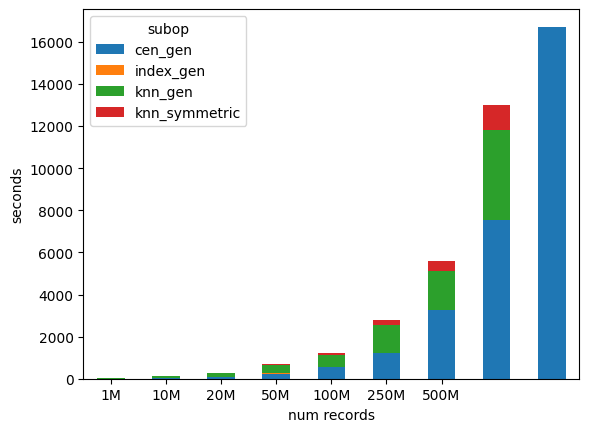

In [39]:

fig, ax = plt.subplots()

g_pivot.plot(kind='bar', stacked=True, ax=ax)
v_df.sort_values(['numrecs'])['walltime'].plot(kind='bar', ax=ax)
plt.ylabel('seconds')
plt.xlabel('num records')

plt.xticks(np.arange(7), ['1M', '10M', '20M', '50M', '100M', '250M', '500M'], rotation=360)

plt.show()


In [40]:
v_df.sort_values(['numrecs'])['walltime'].tolist()[1:]

[7.266338,
 99.458624,
 207.595398,
 570.917262,
 1235.012967,
 3251.802538,
 7522.184411,
 16721.708847]

In [41]:
g_8_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric
numrecs,,,,
1000000,5.297143,0.891214,15.217803,0.742396
10000000,30.657558,8.712012,50.893886,9.838719
20000000,59.583047,18.068238,90.240671,21.893816
50000000,140.690370,50.419851,213.078564,62.713428
100000000,233.563325,99.682349,410.075228,120.497190
250000000,457.853268,263.492696,1001.125809,308.079423
500000000,729.980966,677.910094,2043.945431,572.246576
1000000000,769.586948,1668.483854,4119.150709,1242.667412


In [42]:
# for 8 apu plot: 1m to 500m only

g_8_pivot['vanilla'] = v_df.sort_values(['numrecs'])['walltime'].tolist()[1:]
g_8_pivot


subop,cen_gen,index_gen,knn_gen,knn_symmetric,vanilla
numrecs,,,,,
1000000,5.297143,0.891214,15.217803,0.742396,7.266338
10000000,30.657558,8.712012,50.893886,9.838719,99.458624
20000000,59.583047,18.068238,90.240671,21.893816,207.595398
50000000,140.690370,50.419851,213.078564,62.713428,570.917262
100000000,233.563325,99.682349,410.075228,120.497190,1235.012967
250000000,457.853268,263.492696,1001.125809,308.079423,3251.802538
500000000,729.980966,677.910094,2043.945431,572.246576,7522.184411
1000000000,769.586948,1668.483854,4119.150709,1242.667412,16721.708847


In [43]:
g_pivot['vanilla'] = v_df.sort_values(['numrecs'])['walltime'].tolist()[1:]
g_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric,vanilla
numrecs,,,,,
1000000,8.004755,0.938954,18.877211,0.719176,7.266338
10000000,44.826533,11.759718,83.071893,7.102119,99.458624
20000000,82.985654,21.666023,165.239255,14.505771,207.595398
50000000,218.629373,56.033163,394.741625,42.915334,570.917262
100000000,238.232299,105.779660,767.895688,101.182567,1235.012967
250000000,349.322762,297.052899,1903.636211,227.800315,3251.802538
500000000,689.964442,595.208836,3834.971609,475.139651,7522.184411
1000000000,1691.969357,2358.502926,7786.722898,1150.803178,16721.708847


In [44]:
g_pivot['total'] = g_pivot.iloc[:, :4].sum(axis=1)
g_pivot['total_hours'] = g_pivot['total'] / (60*60)
g_pivot['vanilla_hours'] = g_pivot['vanilla'] / (60*60)
g_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric,vanilla,total,total_hours,vanilla_hours
numrecs,,,,,,,,
1000000,8.004755,0.938954,18.877211,0.719176,7.266338,28.540096,0.007928,0.002018
10000000,44.826533,11.759718,83.071893,7.102119,99.458624,146.760263,0.040767,0.027627
20000000,82.985654,21.666023,165.239255,14.505771,207.595398,284.396703,0.078999,0.057665
50000000,218.629373,56.033163,394.741625,42.915334,570.917262,712.319495,0.197867,0.158588
100000000,238.232299,105.779660,767.895688,101.182567,1235.012967,1213.090214,0.336970,0.343059
250000000,349.322762,297.052899,1903.636211,227.800315,3251.802538,2777.812187,0.771614,0.903278
500000000,689.964442,595.208836,3834.971609,475.139651,7522.184411,5595.284538,1.554246,2.089496
1000000000,1691.969357,2358.502926,7786.722898,1150.803178,16721.708847,12987.998359,3.607777,4.644919


In [23]:
"""# 8 apu vs 4 apu

import seaborn as sns

# data
# gxl - 4 apu
gxl_cen_gen = np.array(g_pivot.cen_gen.tolist()[:6])
gxl_index_gen = np.array(g_pivot.index_gen.tolist()[:6])
gxl_knn_gen = np.array(g_pivot.knn_gen.tolist()[:6])
gxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist()[:6])

# gxl - 8 apu
gxl_cen_gen_8 = np.array(g_8_pivot.cen_gen.tolist())
gxl_index_gen_8 = np.array(g_8_pivot.index_gen.tolist())
gxl_knn_gen_8 = np.array(g_8_pivot.knn_gen.tolist())
gxl_knn_sym_8 = np.array(g_8_pivot.knn_symmetric.tolist())


# data sizes
sizes = ['1M', '10M', '20M', '50M', '100M', '250M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar - 4 apu
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color='#ED0020', label='cen gen')

    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='//', label='knn gen')

    stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='0', label='knn sym')

    stacked_gxl_idx_gen = plt.bar(gxl_pos, gxl_index_gen, bar_width-epsilon, 
                            bottom=gxl_knn_sym+gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='x', label='index gen')

    # gxl stacked bar - 8 apu
    stacked_gxl_cen_gen_8 = plt.bar(v_pos, gxl_cen_gen_8, bar_width, color='#0000DD', label='cen gen')

    stacked_gxl_knn_gen_8 = plt.bar(v_pos, gxl_knn_gen_8, bar_width-epsilon, 
                            bottom=gxl_cen_gen_8, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='//', label='knn gen')

    stacked_gxl_knn_sym_8 = plt.bar(v_pos, gxl_knn_sym_8, bar_width-epsilon, 
                            bottom=gxl_knn_gen_8+gxl_cen_gen_8, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='0', label='knn sym')

    stacked_gxl_idx_gen_8 = plt.bar(v_pos, gxl_index_gen_8, bar_width-epsilon, 
                            bottom=gxl_knn_sym_8+gxl_knn_gen_8+gxl_cen_gen_8, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='x', label='index gen')
    

    plt.xticks(v_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=13)
    sns.despine()

    plt.title('GXL 4 APU vs. 8 APU Index Build Time (Stages) - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_4vs8_index_build_time_stages.png', bbox_inches="tight")
    plt.show()

"""

'# 8 apu vs 4 apu\n\nimport seaborn as sns\n\n# data\n# gxl - 4 apu\ngxl_cen_gen = np.array(g_pivot.cen_gen.tolist()[:6])\ngxl_index_gen = np.array(g_pivot.index_gen.tolist()[:6])\ngxl_knn_gen = np.array(g_pivot.knn_gen.tolist()[:6])\ngxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist()[:6])\n\n# gxl - 8 apu\ngxl_cen_gen_8 = np.array(g_8_pivot.cen_gen.tolist())\ngxl_index_gen_8 = np.array(g_8_pivot.index_gen.tolist())\ngxl_knn_gen_8 = np.array(g_8_pivot.knn_gen.tolist())\ngxl_knn_sym_8 = np.array(g_8_pivot.knn_symmetric.tolist())\n\n\n# data sizes\nsizes = [\'1M\', \'10M\', \'20M\', \'50M\', \'100M\', \'250M\']\n\nwith sns.axes_style("white"):\n    sns.set_style("ticks")\n    sns.set_context("talk")\n    sns.set(rc={\'figure.figsize\':(10, 6)})\n\n    # plot details\n    bar_width = 0.35\n    epsilon = 0.015\n    line_width = 1\n    opacity = 0.7\n    gxl_pos = np.arange(len(gxl_cen_gen))\n    v_pos = gxl_pos + bar_width\n\n    # gxl stacked bar - 4 apu\n    stacked_gxl_cen_gen = plt.

In [22]:
"""# 8 apu vs vanilla
import seaborn as sns

# data
# gxl
gxl_cen_gen = np.array(g_8_pivot.cen_gen.tolist())
gxl_index_gen = np.array(g_8_pivot.index_gen.tolist())
gxl_knn_gen = np.array(g_8_pivot.knn_gen.tolist())
gxl_knn_sym = np.array(g_8_pivot.knn_symmetric.tolist())
# vanilla
vanilla_time = np.array(g_8_pivot.vanilla.tolist())
# data sizes
sizes = ['1M', '10M', '20M', '50M', '100M', '250M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color='#ED0020', label='cen gen')

    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='//', label='knn gen')

    stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='0', label='knn sym')

    stacked_gxl_idx_gen = plt.bar(gxl_pos, gxl_index_gen, bar_width-epsilon, 
                            bottom=gxl_knn_sym+gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='x', label='index gen')
    
    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='#0000DD', label='vanilla')

    plt.xticks(v_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=13)
    sns.despine()

    plt.title('GXL (8 APU) vs. Vanilla HNSWLIB Index Build Time (Stages) - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_8_vanilla_index_build_time_stages.png', bbox_inches="tight")
    plt.show()

"""

'# 8 apu vs vanilla\nimport seaborn as sns\n\n# data\n# gxl\ngxl_cen_gen = np.array(g_8_pivot.cen_gen.tolist())\ngxl_index_gen = np.array(g_8_pivot.index_gen.tolist())\ngxl_knn_gen = np.array(g_8_pivot.knn_gen.tolist())\ngxl_knn_sym = np.array(g_8_pivot.knn_symmetric.tolist())\n# vanilla\nvanilla_time = np.array(g_8_pivot.vanilla.tolist())\n# data sizes\nsizes = [\'1M\', \'10M\', \'20M\', \'50M\', \'100M\', \'250M\']\n\nwith sns.axes_style("white"):\n    sns.set_style("ticks")\n    sns.set_context("talk")\n    sns.set(rc={\'figure.figsize\':(10, 6)})\n\n    # plot details\n    bar_width = 0.35\n    epsilon = 0.015\n    line_width = 1\n    opacity = 0.7\n    gxl_pos = np.arange(len(gxl_cen_gen))\n    v_pos = gxl_pos + bar_width\n\n    # gxl stacked bar\n    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color=\'#ED0020\', label=\'cen gen\')\n\n    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, \n                            bottom=gxl_cen_gen, alph

In [21]:
"""import seaborn as sns

# data
# gxl
gxl_cen_gen = np.array(g_pivot.cen_gen.tolist())
gxl_index_gen = np.array(g_pivot.index_gen.tolist())
gxl_knn_gen = np.array(g_pivot.knn_gen.tolist())
gxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist())
# vanilla
vanilla_time = np.array(g_pivot.vanilla.tolist())
# data sizes
sizes = ['1M', '10M', '20M', '50M', '100M', '250M', '500M', '1000M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color='#ED0020', label='cen gen')

    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='//', label='knn gen')

    stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='0', label='knn sym')

    stacked_gxl_idx_gen = plt.bar(gxl_pos, gxl_index_gen, bar_width-epsilon, 
                            bottom=gxl_knn_sym+gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='x', label='index gen')
    
    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='#0000DD', label='vanilla')

    plt.xticks(v_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=13)
    sns.despine()

    plt.title('GXL vs. Vanilla HNSWLIB Index Build Time (Stages) - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_vanilla_index_build_time_stages.png', bbox_inches="tight")
    plt.show()

"""

'import seaborn as sns\n\n# data\n# gxl\ngxl_cen_gen = np.array(g_pivot.cen_gen.tolist())\ngxl_index_gen = np.array(g_pivot.index_gen.tolist())\ngxl_knn_gen = np.array(g_pivot.knn_gen.tolist())\ngxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist())\n# vanilla\nvanilla_time = np.array(g_pivot.vanilla.tolist())\n# data sizes\nsizes = [\'1M\', \'10M\', \'20M\', \'50M\', \'100M\', \'250M\', \'500M\', \'1000M\']\n\nwith sns.axes_style("white"):\n    sns.set_style("ticks")\n    sns.set_context("talk")\n    sns.set(rc={\'figure.figsize\':(10, 6)})\n\n    # plot details\n    bar_width = 0.35\n    epsilon = 0.015\n    line_width = 1\n    opacity = 0.7\n    gxl_pos = np.arange(len(gxl_cen_gen))\n    v_pos = gxl_pos + bar_width\n\n    # gxl stacked bar\n    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color=\'#ED0020\', label=\'cen gen\')\n\n    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, \n                            bottom=gxl_cen_gen, alpha=opacity

In [20]:
"""import seaborn as sns

# data
# gxl
gxl_time = np.array(g_pivot.total_hours.tolist())
# vanilla
vanilla_time = np.array(g_pivot.vanilla_hours.tolist())
# data sizes
sizes = ['1M', '10M', '20M', '50M', '100M', '250M', '500M', '1000M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_time, bar_width, color='#ED0020', label='gxl')
    
    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='#0000DD', label='vanilla')

    plt.xticks(v_pos, sizes)
    plt.ylabel('hours')
    plt.legend(loc='best', fontsize=13)
    plt.title('GXL vs. Vanilla HNSWLIB Index Build Time - Deep1b', fontsize=13)
    sns.despine()

    plt.savefig('results/vis/gxl_vanilla_index_build_time_hours.png', bbox_inches="tight")
    plt.show()

"""

'import seaborn as sns\n\n# data\n# gxl\ngxl_time = np.array(g_pivot.total_hours.tolist())\n# vanilla\nvanilla_time = np.array(g_pivot.vanilla_hours.tolist())\n# data sizes\nsizes = [\'1M\', \'10M\', \'20M\', \'50M\', \'100M\', \'250M\', \'500M\', \'1000M\']\n\nwith sns.axes_style("white"):\n    sns.set_style("ticks")\n    sns.set_context("talk")\n    sns.set(rc={\'figure.figsize\':(10, 6)})\n\n    # plot details\n    bar_width = 0.35\n    epsilon = 0.015\n    line_width = 1\n    opacity = 0.7\n    gxl_pos = np.arange(len(gxl_cen_gen))\n    v_pos = gxl_pos + bar_width\n\n    # gxl stacked bar\n    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_time, bar_width, color=\'#ED0020\', label=\'gxl\')\n    \n    # vanilla bar\n    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color=\'#0000DD\', label=\'vanilla\')\n\n    plt.xticks(v_pos, sizes)\n    plt.ylabel(\'hours\')\n    plt.legend(loc=\'best\', fontsize=13)\n    plt.title(\'GXL vs. Vanilla HNSWLIB Index Build Time - Deep1b\', fontsiz

In [19]:
"""import seaborn as sns

# data
# gxl
gxl_time = np.array(g_pivot.total_hours.tolist())
# vanilla
vanilla_time = np.array(g_pivot.vanilla_hours.tolist())
# data sizes
sizes = ['1M', '10M', '20M', '50M', '100M', '250M', '500M', '1000M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_time, bar_width, color='#ED0020', label='gxl')
    
    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='#0000DD', label='vanilla')


    # Create a set of inset Axes: these should fill the bounding box allocated to
    # them.
    ax2 = plt.axes([0,0,1,1])
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax1, [0.4,0.2,0.5,0.5])
    ax2.set_axes_locator(ip)
    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # in grey linking the two axes.
    mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

    plt.xticks(v_pos, sizes)
    plt.ylabel('hours')
    plt.legend(loc='best', fontsize=13)
    plt.title('GXL vs. Vanilla HNSWLIB Index Build Time - Deep1b', fontsize=13)
    sns.despine()

    plt.savefig('results/vis/gxl_vanilla_index_build_time_hours.png', bbox_inches="tight")
    plt.show()
"""

'import seaborn as sns\n\n# data\n# gxl\ngxl_time = np.array(g_pivot.total_hours.tolist())\n# vanilla\nvanilla_time = np.array(g_pivot.vanilla_hours.tolist())\n# data sizes\nsizes = [\'1M\', \'10M\', \'20M\', \'50M\', \'100M\', \'250M\', \'500M\', \'1000M\']\n\nwith sns.axes_style("white"):\n    sns.set_style("ticks")\n    sns.set_context("talk")\n    sns.set(rc={\'figure.figsize\':(10, 6)})\n\n    # plot details\n    bar_width = 0.35\n    epsilon = 0.015\n    line_width = 1\n    opacity = 0.7\n    gxl_pos = np.arange(len(gxl_cen_gen))\n    v_pos = gxl_pos + bar_width\n\n    # gxl stacked bar\n    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_time, bar_width, color=\'#ED0020\', label=\'gxl\')\n    \n    # vanilla bar\n    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color=\'#0000DD\', label=\'vanilla\')\n\n\n    # Create a set of inset Axes: these should fill the bounding box allocated to\n    # them.\n    ax2 = plt.axes([0,0,1,1])\n    # Manually set the position and relative si

# numactl
## gxl with numactl vs vanilla

In [18]:
"""import seaborn as sns

# data
# gxl
gxl_cen_gen = np.array(g_numactl_pivot.cen_gen.tolist())
gxl_index_gen = np.array(g_numactl_pivot.index_gen.tolist())
gxl_knn_gen = np.array(g_numactl_pivot.knn_gen.tolist())
gxl_knn_sym = np.array(g_numactl_pivot.knn_symmetric.tolist())
# vanilla
vanilla_time = np.array(g_numactl_pivot.vanilla.tolist())
# data sizes
sizes = ['1M', '10M', '20M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color='#ED0020', label='cen gen')

    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='//', label='knn gen')

    stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='0', label='knn sym')

    stacked_gxl_idx_gen = plt.bar(gxl_pos, gxl_index_gen, bar_width-epsilon, 
                            bottom=gxl_knn_sym+gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='x', label='index gen')
    
    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='#0000DD', label='vanilla')

    plt.xticks(v_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=13)
    sns.despine()

    plt.title('GXL (numactl) vs. Vanilla HNSWLIB Index Build Time (Stages) - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_numactl_vanilla_index_build_time_stages.png', bbox_inches="tight")
    plt.show()

"""

'import seaborn as sns\n\n# data\n# gxl\ngxl_cen_gen = np.array(g_numactl_pivot.cen_gen.tolist())\ngxl_index_gen = np.array(g_numactl_pivot.index_gen.tolist())\ngxl_knn_gen = np.array(g_numactl_pivot.knn_gen.tolist())\ngxl_knn_sym = np.array(g_numactl_pivot.knn_symmetric.tolist())\n# vanilla\nvanilla_time = np.array(g_numactl_pivot.vanilla.tolist())\n# data sizes\nsizes = [\'1M\', \'10M\', \'20M\']\n\nwith sns.axes_style("white"):\n    sns.set_style("ticks")\n    sns.set_context("talk")\n    sns.set(rc={\'figure.figsize\':(10, 6)})\n\n    # plot details\n    bar_width = 0.35\n    epsilon = 0.015\n    line_width = 1\n    opacity = 0.7\n    gxl_pos = np.arange(len(gxl_cen_gen))\n    v_pos = gxl_pos + bar_width\n\n    # gxl stacked bar\n    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color=\'#ED0020\', label=\'cen gen\')\n\n    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, \n                            bottom=gxl_cen_gen, alpha=opacity, color=\'

## gxl with vs without numactl

In [17]:
"""import seaborn as sns

# data
# gxl
gxl_cen_gen = np.array(g_pivot.cen_gen.tolist())[:3]
gxl_index_gen = np.array(g_pivot.index_gen.tolist())[:3]
gxl_knn_gen = np.array(g_pivot.knn_gen.tolist())[:3]
gxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist())[:3]

# gxl numactl
gxl_numactl_cen_gen = np.array(g_numactl_pivot.cen_gen.tolist())
gxl_numactl_index_gen = np.array(g_numactl_pivot.index_gen.tolist())
gxl_numactl_knn_gen = np.array(g_numactl_pivot.knn_gen.tolist())
gxl_numactl_knn_sym = np.array(g_numactl_pivot.knn_symmetric.tolist())

# data sizes
sizes = ['1M', '10M', '20M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.35
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    v_pos = gxl_pos + bar_width

    # gxl stacked bar
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color='#ED0020', label='cen gen w/o')

    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='//', label='knn gen w/o')

    stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='0', label='knn sym w/o')

    stacked_gxl_idx_gen = plt.bar(gxl_pos, gxl_index_gen, bar_width-epsilon, 
                            bottom=gxl_knn_sym+gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='x', label='index gen w/o')

    # numactl
    stacked_gxl_numactl_cen_gen = plt.bar(v_pos, gxl_numactl_cen_gen, bar_width, color='#0000DD', label='cen gen')

    stacked_gxl_numactl_knn_gen = plt.bar(v_pos, gxl_numactl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_numactl_cen_gen, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='//', label='knn gen')

    stacked_gxl_numactl_knn_sym = plt.bar(v_pos, gxl_numactl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_numactl_knn_gen+gxl_numactl_cen_gen, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='0', label='knn sym')

    stacked_gxl_numactl_idx_gen = plt.bar(v_pos, gxl_numactl_index_gen, bar_width-epsilon, 
                            bottom=gxl_numactl_knn_sym+gxl_numactl_knn_gen+gxl_numactl_cen_gen, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='x', label='index gen')

    plt.xticks(v_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=13)
    sns.despine()

    plt.title('GXL With vs. Without Numactl HNSWLIB Index Build Time (Stages) - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_numactl_with_without_index_build_time_stages.png', bbox_inches="tight")
    plt.show()

"""

'import seaborn as sns\n\n# data\n# gxl\ngxl_cen_gen = np.array(g_pivot.cen_gen.tolist())[:3]\ngxl_index_gen = np.array(g_pivot.index_gen.tolist())[:3]\ngxl_knn_gen = np.array(g_pivot.knn_gen.tolist())[:3]\ngxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist())[:3]\n\n# gxl numactl\ngxl_numactl_cen_gen = np.array(g_numactl_pivot.cen_gen.tolist())\ngxl_numactl_index_gen = np.array(g_numactl_pivot.index_gen.tolist())\ngxl_numactl_knn_gen = np.array(g_numactl_pivot.knn_gen.tolist())\ngxl_numactl_knn_sym = np.array(g_numactl_pivot.knn_symmetric.tolist())\n\n# data sizes\nsizes = [\'1M\', \'10M\', \'20M\']\n\nwith sns.axes_style("white"):\n    sns.set_style("ticks")\n    sns.set_context("talk")\n    sns.set(rc={\'figure.figsize\':(10, 6)})\n\n    # plot details\n    bar_width = 0.35\n    epsilon = 0.015\n    line_width = 1\n    opacity = 0.7\n    gxl_pos = np.arange(len(gxl_cen_gen))\n    v_pos = gxl_pos + bar_width\n\n    # gxl stacked bar\n    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_ce

# gxl 4 vs 8 apu vs vanilla

In [16]:
"""# 8 apu vs 4 apu

import seaborn as sns

# data
# gxl - 4 apu
gxl_cen_gen = np.array(g_pivot.cen_gen.tolist()[:6])
gxl_index_gen = np.array(g_pivot.index_gen.tolist()[:6])
gxl_knn_gen = np.array(g_pivot.knn_gen.tolist()[:6])
gxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist()[:6])

# gxl - 8 apu
gxl_cen_gen_8 = np.array(g_8_pivot.cen_gen.tolist())
gxl_index_gen_8 = np.array(g_8_pivot.index_gen.tolist())
gxl_knn_gen_8 = np.array(g_8_pivot.knn_gen.tolist())
gxl_knn_sym_8 = np.array(g_8_pivot.knn_symmetric.tolist())

# vanilla
vanilla_time = np.array(g_8_pivot.vanilla.tolist())

# data sizes
sizes = ['1M', '10M', '20M', '50M', '100M', '250M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.3
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    gxl_pos = np.arange(len(gxl_cen_gen))
    gxl_8_pos = gxl_pos + bar_width
    v_pos = gxl_8_pos + bar_width


    # gxl stacked bar - 4 apu
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color='#ED0020', label='cen gen (4 APU)')

    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='//', label='knn gen (4 APU)')

    stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='0', label='knn sym (4 APU)')

    stacked_gxl_idx_gen = plt.bar(gxl_pos, gxl_index_gen, bar_width-epsilon, 
                            bottom=gxl_knn_sym+gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='#ED0020',
                            linewidth=line_width, hatch='x', label='index gen (4 APU)')

    # gxl stacked bar - 8 apu
    stacked_gxl_cen_gen_8 = plt.bar(gxl_8_pos, gxl_cen_gen_8, bar_width, color='#0000DD', label='cen gen (8 APU)')

    stacked_gxl_knn_gen_8 = plt.bar(gxl_8_pos, gxl_knn_gen_8, bar_width-epsilon, 
                            bottom=gxl_cen_gen_8, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='//', label='knn gen (8 APU)')

    stacked_gxl_knn_sym_8 = plt.bar(gxl_8_pos, gxl_knn_sym_8, bar_width-epsilon, 
                            bottom=gxl_knn_gen_8+gxl_cen_gen_8, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='0', label='knn sym (8 APU)')

    stacked_gxl_idx_gen_8 = plt.bar(gxl_8_pos, gxl_index_gen_8, bar_width-epsilon, 
                            bottom=gxl_knn_sym_8+gxl_knn_gen_8+gxl_cen_gen_8, alpha=opacity, color='white', edgecolor='#0000DD',
                            linewidth=line_width, hatch='x', label='index gen (8 APU)')

    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='#71C671', label='vanilla')

    plt.xticks(v_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=13)
    sns.despine()

    plt.title('GXL 4 APU vs. 8 APU  vs. Vanilla Index Build Time (Stages) - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_4vs8__vanilla_index_build_time_stages.png', bbox_inches="tight")
    plt.show()

"""

'# 8 apu vs 4 apu\n\nimport seaborn as sns\n\n# data\n# gxl - 4 apu\ngxl_cen_gen = np.array(g_pivot.cen_gen.tolist()[:6])\ngxl_index_gen = np.array(g_pivot.index_gen.tolist()[:6])\ngxl_knn_gen = np.array(g_pivot.knn_gen.tolist()[:6])\ngxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist()[:6])\n\n# gxl - 8 apu\ngxl_cen_gen_8 = np.array(g_8_pivot.cen_gen.tolist())\ngxl_index_gen_8 = np.array(g_8_pivot.index_gen.tolist())\ngxl_knn_gen_8 = np.array(g_8_pivot.knn_gen.tolist())\ngxl_knn_sym_8 = np.array(g_8_pivot.knn_symmetric.tolist())\n\n# vanilla\nvanilla_time = np.array(g_8_pivot.vanilla.tolist())\n\n# data sizes\nsizes = [\'1M\', \'10M\', \'20M\', \'50M\', \'100M\', \'250M\']\n\nwith sns.axes_style("white"):\n    sns.set_style("ticks")\n    sns.set_context("talk")\n    sns.set(rc={\'figure.figsize\':(10, 6)})\n\n    # plot details\n    bar_width = 0.3\n    epsilon = 0.015\n    line_width = 1\n    opacity = 0.7\n    gxl_pos = np.arange(len(gxl_cen_gen))\n    gxl_8_pos = gxl_pos + bar_wid

In [ ]:
g_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric,vanilla,total,total_hours,vanilla_hours
numrecs,,,,,,,,
1000000,8.004755,0.938954,18.877211,0.719176,7.223935,28.540096,0.007928,0.002007
10000000,44.826533,11.759718,83.071893,7.102119,95.257398,146.760263,0.040767,0.026460
20000000,82.985654,21.666023,165.239255,14.505771,207.595398,284.396703,0.078999,0.057665
50000000,218.629373,56.033163,394.741625,42.915334,570.917262,712.319495,0.197867,0.158588
100000000,238.232299,105.779660,767.895688,101.182567,1212.855125,1213.090214,0.336970,0.336904
250000000,349.322762,297.052899,1903.636211,227.800315,3251.802538,2777.812187,0.771614,0.903278
500000000,689.964442,595.208836,3834.971609,475.139651,7522.184411,5595.284538,1.554246,2.089496
1000000000,1691.969357,2358.502926,7786.722898,1150.803178,0.000000,12987.998359,3.607777,0.000000


In [45]:
g_8_pivot['total'] = g_8_pivot.iloc[:, :4].sum(axis=1)
g_8_pivot['total_hours'] = g_8_pivot['total'] / (60*60)
g_8_pivot

subop,cen_gen,index_gen,knn_gen,knn_symmetric,vanilla,total,total_hours
numrecs,,,,,,,
1000000,5.297143,0.891214,15.217803,0.742396,7.266338,22.148556,0.006152
10000000,30.657558,8.712012,50.893886,9.838719,99.458624,100.102175,0.027806
20000000,59.583047,18.068238,90.240671,21.893816,207.595398,189.785772,0.052718
50000000,140.690370,50.419851,213.078564,62.713428,570.917262,466.902213,0.129695
100000000,233.563325,99.682349,410.075228,120.497190,1235.012967,863.818092,0.239949
250000000,457.853268,263.492696,1001.125809,308.079423,3251.802538,2030.551196,0.564042
500000000,729.980966,677.910094,2043.945431,572.246576,7522.184411,4024.083067,1.117801
1000000000,769.586948,1668.483854,4119.150709,1242.667412,16721.708847,7799.888923,2.166636


Rectangle(xy=(-0.1, 0), width=0.2, height=1213.09, angle=0)
Rectangle(xy=(0.9, 0), width=0.2, height=2777.81, angle=0)
Rectangle(xy=(1.9, 0), width=0.2, height=5595.28, angle=0)
Rectangle(xy=(2.9, 0), width=0.2, height=12988, angle=0)
Rectangle(xy=(0.1, 0), width=0.2, height=863.818, angle=0)
Rectangle(xy=(1.1, 0), width=0.2, height=2030.55, angle=0)
Rectangle(xy=(2.1, 0), width=0.2, height=4024.08, angle=0)
Rectangle(xy=(3.1, 0), width=0.2, height=7799.89, angle=0)


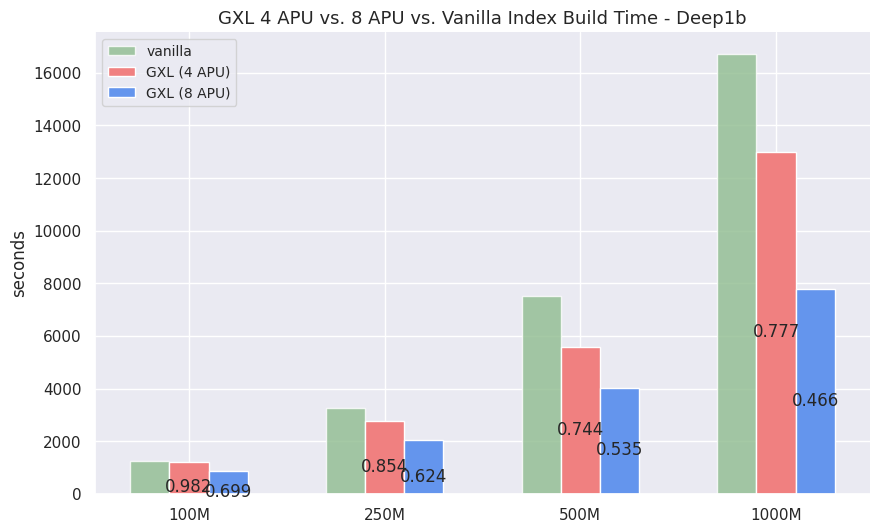

In [46]:
# 8 apu vs 4 apu vs vanilla

import seaborn as sns

# data
# gxl - 4 apu
gxl_4 = np.array(g_pivot.total.tolist()[4:])

# gxl - 8 apu
gxl_8 = np.array(g_8_pivot.total.tolist()[4:])

# vanilla
vanilla_time = np.array(g_8_pivot.vanilla.tolist()[4:])

# data sizes
sizes = ['100M', '250M', '500M', '1000M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.2
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    """v_pos = np.arange(len(gxl_4))
    gxl_pos = v_pos + bar_width
    gxl_8_pos = gxl_pos + bar_width"""

    gxl_pos = np.arange(len(gxl_4))
    v_pos = gxl_pos - bar_width
    gxl_8_pos = gxl_pos + bar_width

    fig, ax = plt.subplots()

    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='darkseagreen', label='vanilla', alpha=0.8)

    # gxl stacked bar - 4 apu
    bar_gxl_4 = plt.bar(gxl_pos, gxl_4, bar_width, color='lightcoral', label='GXL (4 APU)')

    # gxl stacked bar - 8 apu
    bar_gxl_cen_gen_8 = plt.bar(gxl_8_pos, gxl_8, bar_width, color='cornflowerblue', label='GXL (8 APU)')

    for i in range(len(ax.patches)):
        # 012, 345, 678
        # 0
        if i in [4, 8]:
            og = ax.patches[0]
            patch = ax.patches[i]
            lbl = round(patch.get_height()/og.get_height(), 3)
            print(patch)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height()/2, f'{lbl}', 
            verticalalignment='top', horizontalalignment='center')

        # 1
        if i in [5, 9]:
            og = ax.patches[1]
            patch = ax.patches[i]
            lbl = round(patch.get_height()/og.get_height(), 3)
            print(patch)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height()/2, f'{lbl}', 
            verticalalignment='top', horizontalalignment='center')

        # 2
        if i in [6, 10]:
            og = ax.patches[2]
            patch = ax.patches[i]
            lbl = round(patch.get_height()/og.get_height(), 3)
            print(patch)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height()/2, f'{lbl}', 
            verticalalignment='top', horizontalalignment='center')

        # 3
        if i in [7, 11]:
            og = ax.patches[3]
            patch = ax.patches[i]
            lbl = round(patch.get_height()/og.get_height(), 3)
            print(patch)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height()/2, f'{lbl}', 
            verticalalignment='top', horizontalalignment='center')


    plt.xticks(gxl_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='upper left', fontsize=10)
    sns.despine()

    plt.title('GXL 4 APU vs. 8 APU vs. Vanilla Index Build Time - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_4vs8__vanilla_index_build_time_total.png', bbox_inches="tight")
    plt.show()



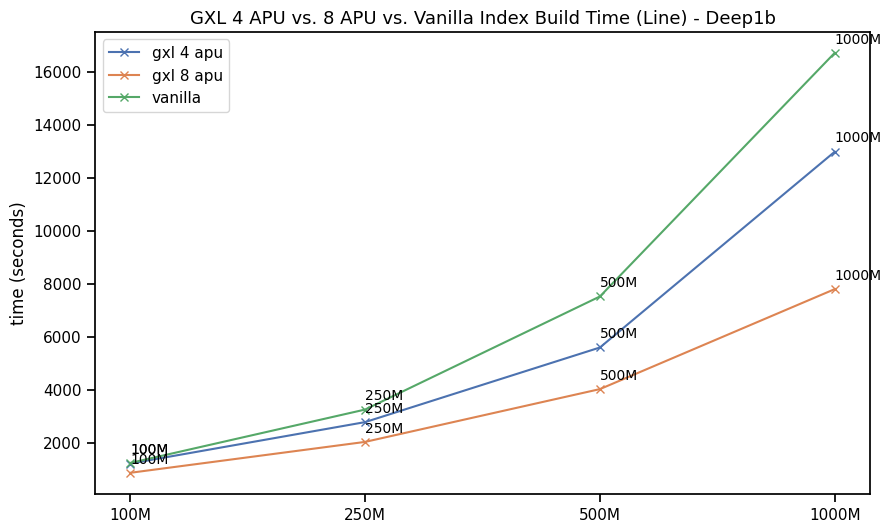

In [83]:
# data
# gxl - 4 apu
gxl_4 = np.array(g_pivot.total.tolist()[4:])

# gxl - 8 apu
gxl_8 = np.array(g_8_pivot.total.tolist()[4:])

# vanilla
vanilla_time = np.array(g_8_pivot.vanilla.tolist()[4:])

# data sizes
sizes = ['100M', '250M', '500M', '1000M']

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(gxl_4, marker='x', label='gxl 4 apu')
ax.plot(gxl_8, marker='x', label='gxl 8 apu')
ax.plot(vanilla_time, marker='x', label='vanilla')

for i, s in enumerate(sizes):
    ax.annotate(s, 
        xy=(i, gxl_4[i]-0.005), 
        xytext=(0.0,7),
        textcoords="offset points", 
        fontsize=10
        )

for i, s in enumerate(sizes):
    ax.annotate(s, 
        xy=(i, gxl_8[i]-0.005 ), 
        xytext=(0.0,7),
        textcoords="offset points", 
        fontsize=10
        )

for i, s in enumerate(sizes):
    ax.annotate(s, 
        xy=(i, vanilla_time[i]-0.005 ), 
        xytext=(0.0,7),
        textcoords="offset points", 
        fontsize=10
        )

plt.legend()
plt.xticks(np.arange(4), sizes)
plt.ylabel('time (seconds)')
plt.title('GXL 4 APU vs. 8 APU vs. Vanilla Index Build Time (Line) - Deep1b', fontsize=13)
plt.savefig('results/vis/gxl_4vs8__vanilla_index_build_time_line.png', bbox_inches="tight")
plt.show()
plt.close()

In [58]:
for i, s in enumerate(sizes):
    print(i)
    print(s)

0
100M
1
250M
2
500M
3
1000M


/tmp/ipykernel_300171/806910013.py:48: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "0". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon,
/tmp/ipykernel_300171/806910013.py:63: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "0". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  stacked_gxl_knn_sym_8 = plt.bar(gxl_8_pos, gxl_knn_sym_8, bar_width-epsilon,


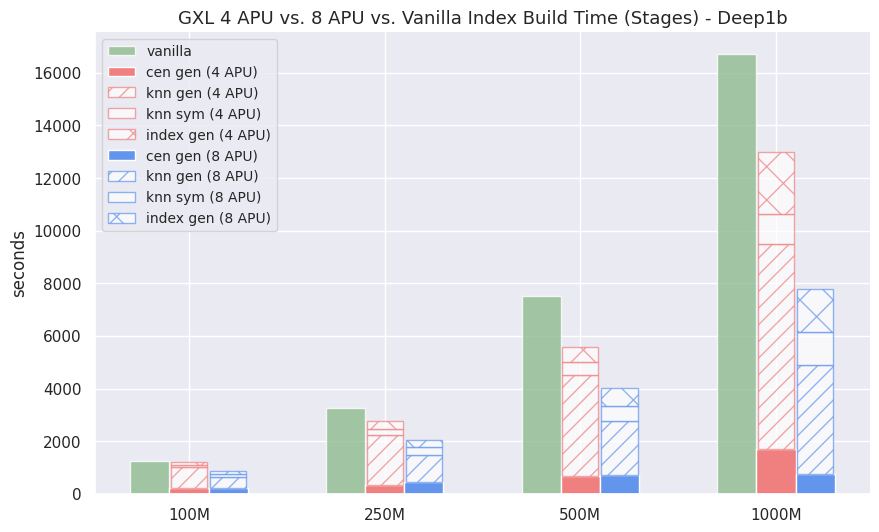

In [47]:
# 8 apu vs 4 apu

import seaborn as sns

# data
# gxl - 4 apu
gxl_cen_gen = np.array(g_pivot.cen_gen.tolist()[4:])
gxl_index_gen = np.array(g_pivot.index_gen.tolist()[4:])
gxl_knn_gen = np.array(g_pivot.knn_gen.tolist()[4:])
gxl_knn_sym = np.array(g_pivot.knn_symmetric.tolist()[4:])

# gxl - 8 apu
gxl_cen_gen_8 = np.array(g_8_pivot.cen_gen.tolist()[4:])
gxl_index_gen_8 = np.array(g_8_pivot.index_gen.tolist()[4:])
gxl_knn_gen_8 = np.array(g_8_pivot.knn_gen.tolist()[4:])
gxl_knn_sym_8 = np.array(g_8_pivot.knn_symmetric.tolist()[4:])

# vanilla
vanilla_time = np.array(g_8_pivot.vanilla.tolist()[4:])

# data sizes
sizes = ['100M', '250M', '500M', '1000M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.2
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    v_pos = np.arange(len(gxl_cen_gen))
    gxl_pos = v_pos + bar_width
    gxl_8_pos = gxl_pos + bar_width

    # vanilla bar
    bar_vanilla = plt.bar(v_pos, vanilla_time, bar_width, color='darkseagreen', label='vanilla', alpha=0.8)

    # gxl stacked bar - 4 apu
    stacked_gxl_cen_gen = plt.bar(gxl_pos, gxl_cen_gen, bar_width, color='lightcoral', label='cen gen (4 APU)')

    stacked_gxl_knn_gen = plt.bar(gxl_pos, gxl_knn_gen, bar_width-epsilon, 
                            bottom=gxl_cen_gen, alpha=opacity, color='white', edgecolor='lightcoral',
                            linewidth=line_width, hatch='//', label='knn gen (4 APU)')

    stacked_gxl_knn_sym = plt.bar(gxl_pos, gxl_knn_sym, bar_width-epsilon, 
                            bottom=gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='lightcoral',
                            linewidth=line_width, hatch='0', label='knn sym (4 APU)')

    stacked_gxl_idx_gen = plt.bar(gxl_pos, gxl_index_gen, bar_width-epsilon, 
                            bottom=gxl_knn_sym+gxl_knn_gen+gxl_cen_gen, alpha=opacity, color='white', edgecolor='lightcoral',
                            linewidth=line_width, hatch='x', label='index gen (4 APU)')

    # gxl stacked bar - 8 apu
    stacked_gxl_cen_gen_8 = plt.bar(gxl_8_pos, gxl_cen_gen_8, bar_width, color='cornflowerblue', label='cen gen (8 APU)')

    stacked_gxl_knn_gen_8 = plt.bar(gxl_8_pos, gxl_knn_gen_8, bar_width-epsilon, 
                            bottom=gxl_cen_gen_8, alpha=opacity, color='white', edgecolor='cornflowerblue',
                            linewidth=line_width, hatch='//', label='knn gen (8 APU)')

    stacked_gxl_knn_sym_8 = plt.bar(gxl_8_pos, gxl_knn_sym_8, bar_width-epsilon, 
                            bottom=gxl_knn_gen_8+gxl_cen_gen_8, alpha=opacity, color='white', edgecolor='cornflowerblue',
                            linewidth=line_width, hatch='0', label='knn sym (8 APU)')

    stacked_gxl_idx_gen_8 = plt.bar(gxl_8_pos, gxl_index_gen_8, bar_width-epsilon, 
                            bottom=gxl_knn_sym_8+gxl_knn_gen_8+gxl_cen_gen_8, alpha=opacity, color='white', edgecolor='cornflowerblue',
                            linewidth=line_width, hatch='x', label='index gen (8 APU)')


    

    plt.xticks(gxl_pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='best', fontsize=10)
    sns.despine()

    plt.title('GXL 4 APU vs. 8 APU vs. Vanilla Index Build Time (Stages) - Deep1b', fontsize=13)

    plt.savefig('results/vis/gxl_4vs8__vanilla_index_build_time_stages.png', bbox_inches="tight")
    plt.show()

